# Expérience de vérification automatisée de la qualité lors de la collecte de vidéos YouTube

Ce notebook implémente une chaîne automatisée de collecte et de contrôle qualité des vidéos issues de YouTube, dans le cadre de la création d'archives de jouabilité.

L'objectif est de garantir l'intégrité, la lisibilité et la cohérence des vidéos collectées tout en réduisant le travail manuel.  
Pour chaque vidéo, le notebook effectue les étapes suivantes :

1. **Téléchargement automatisé** via `yt-dlp` en format MP4.
2. **Contrôle d'intégrité** en calculant une empreinte SHA-256.
3. **Vérification technique** de la lisibilité avec `ffmpeg`.
4. **Collecte de métadonnées** (taille, durée, statut) dans un fichier CSV.

Le notebook est conçu pour être exécuté sur Google Colab ou en local sur un système Linux et peut être adapté à tout corpus de vidéos YouTube destiné à des études de jouabilité ou à la constitution d'archives numériques.

# 1. Installation et importation des dépendances

Assurez-vous d'avoir installé `ffmpeg` en exécutant la commande suivante :

```bash
sudo apt-get install ffmpeg
```

In [1]:
%%capture
# Installer les packages nécessaires
%pip install yt-dlp
%pip install pymediainfo
%pip install pandas
%pip install matplotlib
%pip install ffmpeg-python;

In [2]:
# Importer les packages nécessaires
import os
import hashlib
import pandas as pd
from datetime import datetime, timedelta
import yt_dlp
from pathlib import Path
from pymediainfo import MediaInfo
import ffmpeg
import warnings


# 2. Configuration des chemins et paramètres

In [3]:
# Dossier de travail
root = Path("./")
output_dir = root / "game_archives"
os.makedirs(output_dir, exist_ok=True)

# URL YouTube exemple from the New World Aeternum official YouTube Channel
youtube_urls = [
    "https://www.youtube.com/watch?v=VDOjE9mTY5Y",  # 19 min 42 : Forged in Aeternum - Community Q&A (July 2025)
    "https://www.youtube.com/watch?v=RvzSZupZcDI",  # 21 min 04 : New World: Dev Update - July 2025
    "https://www.youtube.com/watch?v=2qRVEk_IiJU",  # 17 min 41 : New World: Aeternum - Capture the Flag
    "https://youtu.be/8R6fQ9Z107U?si=IKVcmiPbd4RFSOho",
    "https://youtu.be/hhHUIsR6MWg?si=cVN5temFn90SOqcx",
    "https://youtu.be/-j3-RM4DGuo?si=BcaUmYK86_duTp9k",
    "https://youtu.be/P0fDWDP49Gg?si=52r3vGJNkBEInkiS",
    "https://youtu.be/ALR3yu6zoy8?si=qPOlH1M5vwY7i6Ab",
    "https://youtu.be/4__Ojun3Q3k?si=MDks9nrPxgZqdgsG",
    "https://youtu.be/M4xw-_sEoEY?si=8E-19SLitUmmha-1",
    "https://youtu.be/1_PZQFDfZzM?si=PCDO_mDdkAj3w8hh",
    "https://youtu.be/Q-X9oXJAvy4?si=frG2if-xXzth68j2",
    "https://youtu.be/VR_VjR7ZtZw?si=jspNkTUUnURHV7dO",
    "https://youtu.be/VR_VjR7ZtZw?si=Owaftp2v-gsAaX0s",
    "https://youtu.be/l_jBmrIGDZc?si=tr0SDr4ZnH0IrCok",
    "https://youtu.be/2-sUnLH94wk?si=YeqE9CxbxgZaPZX1",
    "https://youtu.be/yCW1sl1nVpM?si=t91GuxVMTuxzFFgZ",
    "https://youtu.be/NNa5517I7cg?si=pJxS9TxFYTHflZ8a",
    "https://youtu.be/xAggW8Wqn78?si=zf21o8jt4aS1dOjx",
    "https://youtu.be/ljBbsjjftE8?si=hQBWL737Gwuzworv",
    "https://www.youtube.com/live/b7rpYxXPbEU?si=itXi7pALLU8gbzrA",
    "https://youtu.be/BnrGjTVBEy4?si=QEnENTSGhyPpABBc",
]

# Fichier CSV pour métadonnées
metadata_file = output_dir / "metadata.csv"

# Initialiser un DataFrame pour stocker les métadonnées
metadata_df = pd.DataFrame(columns=[
    "url", "filename", "sha256", "size_bytes", "duration_seconds", "status", "timestamp"
])


# 3. Fonctions utilitaires

In [4]:
# Fonction pour calculer l'empreinte SHA-256
def compute_sha256(file_path):
    sha256_hash = hashlib.sha256()
    with open(file_path, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()

In [5]:
def ffmpeg_check(filename, error_detect='default', threads=0) -> bool:
    """Vérifie l'intégrité d'un fichier vidéo à l'aide de ffmpeg.

    Args:
        filename (str): Le chemin du fichier vidéo à vérifier.
        error_detect (str, optional): Méthode de détection des erreurs. Defaults to 'default'.
        threads (int, optional): Nombre de threads à utiliser. Defaults to 0.

    Source:
        code from https://github.com/ftarlao/check-media-integrity/blob/ae994ae9819d915148d1b3b35ff07ceb80ed0915/check_mi.py#L236

    Raises:
        ffmpeg.Error: Si une erreur ffmpeg se produit.

    Returns:
        bool: True si le fichier est valide, False sinon.
    """
    ffargs = {'loglevel': 'error', 'threads': threads}
    check_stderr = False
    if error_detect != 'default':
        if error_detect == 'strict':
            error_detect = '+crccheck+bitstream+buffer+explode'
        if 'xerror' in error_detect:
            ffargs['xerror'] = None
            error_detect = error_detect.replace('xerror', '')
        if 'stderr' in error_detect:
            check_stderr = True
            error_detect = error_detect.replace('stderr', '')
        if error_detect:
            ffargs.update({'err_detect': error_detect})

    stream = ffmpeg.input(filename, **ffargs).output('pipe:', format="null")
    try:
        stdout, stderr = stream.run(capture_stdout=True, capture_stderr=True, input='')
        if check_stderr and stderr:
            raise ffmpeg.Error(stream, stdout, stderr)
        return True
    except ffmpeg.Error as e:
        warnings.warn(
            'ffmpeg error: ' +
            e.stderr.rstrip().rsplit(b"\n", 1)[-1].decode("utf-8"),
            category=UserWarning,
            stacklevel=2,
        )
        return False

# 4. Téléchargement et contrôle automatisé

> **Avertissement**
>
> Nous altérons le status tous les trois fichiers pour obtenir artificiellement des fichiers corrompus.


In [6]:
data = []

media_info_labels = [
    "track_type",
    "complete_name",
    "format",
    "format_profile",
    "codec_id",
    "file_size",
    "duration",
    "overall_bit_rate_mode",
    "overall_bit_rate",
    "frame_rate",
    "writing_application"
]

for i, url in enumerate(youtube_urls):
    timestamp = datetime.now().isoformat()
    ydl_opts = {
        'format': 'mp4',
        'outtmpl': str(output_dir / "data" / '%(title)s.%(ext)s'),
        'quiet': True
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        filepath = ydl.prepare_filename(info_dict)

    status = 1 if ffmpeg_check(filepath) and (i+1)%3!=0 else 0
    sha256 = compute_sha256(filepath)
    media_info_dict = MediaInfo.parse(filepath, full=True).general_tracks[0].to_data()
    data_dict = {k: v for k, v in media_info_dict.items() if k in media_info_labels}
    # convert duration into timedelta
    data_dict['duration'] = int(timedelta(milliseconds=data_dict['duration']).total_seconds())
    data_dict.update({
        "url": url,
        "status": status,
        "timestamp": timestamp,
        "sha256": sha256,
        "name": Path(filepath).stem.replace("：", ":").replace("  ", " "),
    })
    data.append(data_dict)

metadata_df = pd.DataFrame(data)

# Sauvegarder les métadonnées
metadata_df.to_csv(metadata_file, index=False)
metadata_df.head()


,track_type,complete_name,format,format_profile,codec_id,file_size,duration,overall_bit_rate_mode,overall_bit_rate,frame_rate,writing_application,url,status,timestamp,sha256,name
0,General,game_archives/data/Forged in Aeternum - Commu...,MPEG-4,Base Media / Version 2,mp42,53777879,1182,VBR,363968,23.976,Google,https://www.youtube.com/watch?v=VDOjE9mTY5Y,1,2025-08-27T20:44:17.976969,2698a93ef75c670ce08d0ab9954bd3ae5387c3d3f7b75e...,Forged in Aeternum - Community Q&A (July 2025)
1,General,game_archives/data/New World： Dev Update - Ju...,MPEG-4,Base Media / Version 2,mp42,64221820,1264,VBR,406191,23.976,Google,https://www.youtube.com/watch?v=RvzSZupZcDI,1,2025-08-27T20:45:01.117702,9afa59e7aa3b751af68777403553ef3e85914ac75b300d...,New World: Dev Update - July 2025
2,General,game_archives/data/New World： Aeternum - Captu...,MPEG-4,Base Media / Version 2,mp42,82445097,1061,VBR,621239,24.000,Google,https://www.youtube.com/watch?v=2qRVEk_IiJU,0,2025-08-27T20:45:43.487931,fd141a285a064c163b0a43f494d33e1eabcaf479e00400...,New World: Aeternum - Capture the Flag
3,General,game_archives/data/New World： Dev Update - Feb...,MPEG-4,Base Media / Version 2,mp42,38069031,921,VBR,330494,23.976,NaN,https://youtu.be/8R6fQ9Z107U?si=IKVcmiPbd4RFSOho,1,2025-08-27T20:46:26.083337,6a4c02ce31159486791ab57f9172ee95e32742011a2ce9...,New World: Dev Update - February 2024
4,General,game_archives/data/New World： Dev Update - Wha...,MPEG-4,Base Media / Version 2,mp42,17094525,558,VBR,244788,29.970,NaN,https://youtu.be/hhHUIsR6MWg?si=cVN5temFn90SOqcx,1,2025-08-27T20:47:00.663801,d1e9f3200e3840c62ce1fbc8829a2958b991c9822568b0...,New World: Dev Update - What's Next for New World


# 5. Rapports et contrôle statistique simple

In [7]:
# Nombre de vidéos téléchargées
print(f"Total vidéos : {len(metadata_df)}")

# Statut
print(metadata_df['status'].value_counts())

# Durée totale
print(f"Durée totale : {timedelta(seconds=metadata_df['duration'].sum().item())}")

# Taille totale (octets)
print(f"Taille totale : {metadata_df['file_size'].sum().item()} octets")


Total vidéos : 22
status
1    15
0     7
Name: count, dtype: int64
Durée totale : 9:21:48
Taille totale : 1846912743 octets


# 6. Visualisation des statistiques de contrôle

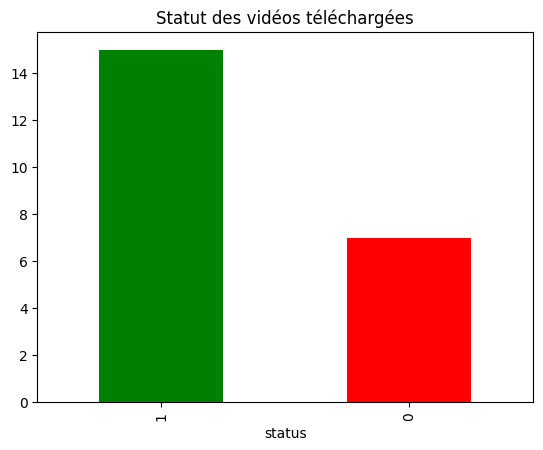

In [8]:
# Graphique 1 : Statut des vidéos
metadata_df['status'].value_counts().plot(kind='bar', title='Statut des vidéos téléchargées', color=["green", "red"]);

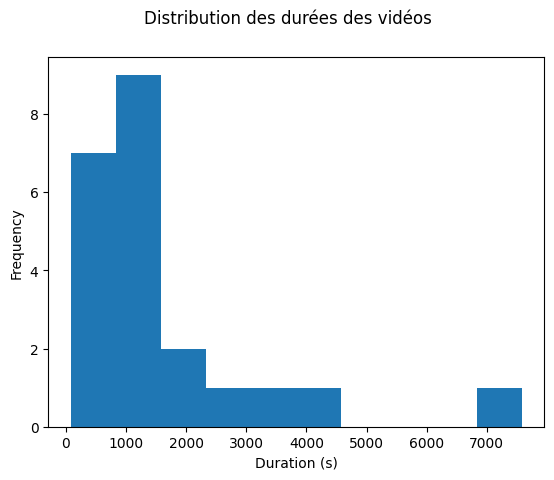

In [9]:
# Graphique 2 : Distribution des durées
metadata_df['duration'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Distribution des durées des vidéos', xlabel="Duration (s)");

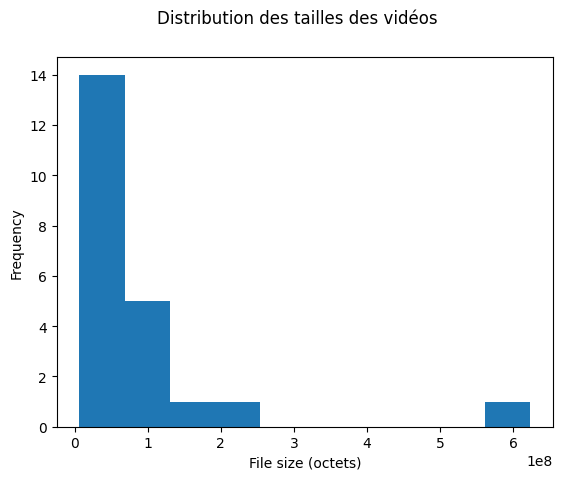

In [10]:
# Graphique 3 : Taille des fichiers
metadata_df['file_size'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Distribution des tailles des vidéos', xlabel="File size (octets)");

## 6.1. Diagramme de type "status par durée et taille"
Chaque point = une vidéo

Axe X = durée, Axe Y = taille du fichier

Couleur = statut (1.0=OK, 0.0=Corrompu)

Taille du point = volume du fichier (optionnel)

Permet de repérer d’un coup les vidéos anormales.

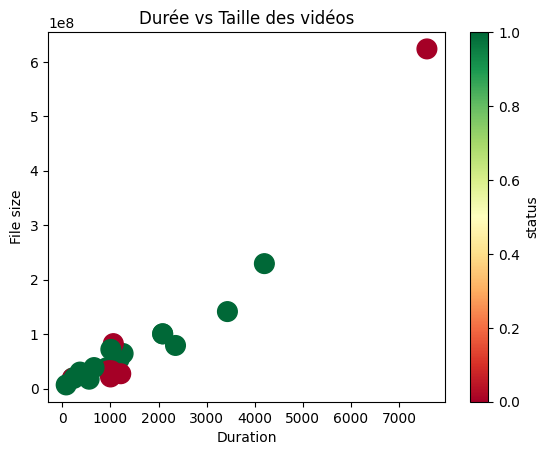

In [11]:
metadata_df.plot.scatter(
    x='duration',
    y='file_size',
    c='status',
    colormap='RdYlGn',
    vmin=0,
    vmax=1,
    title='Durée vs Taille des vidéos',
    s=200,
    xlabel="Duration",
    ylabel="File size",
);

## 6.2. Chronologie des téléchargements
Affiche quand chaque vidéo a été collectée

Permet de suivre l’activité et de détecter des interruptions ou échecs dans le temps.

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 10744 (\N{BIG SOLIDUS}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10744 (\N{BIG SOLIDUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


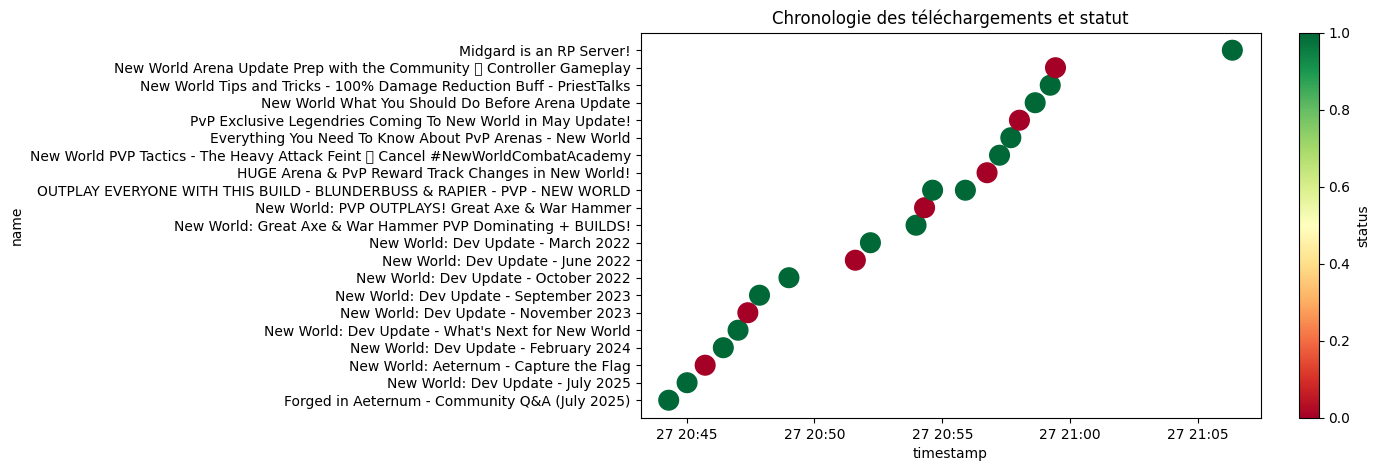

In [12]:
metadata_df['timestamp'] = pd.to_datetime(metadata_df['timestamp'], utc=True)
metadata_df.plot.scatter(
    x='timestamp',
    y='name',
    c='status',
    colormap='RdYlGn',
    vmin=0,
    vmax=1,
    title='Chronologie des téléchargements et statut',
    figsize=(10, 5),
    s=200,
);